In [1]:
import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt

**NOTE** The results files have been renamed but the weights files not. They are named by time, and the runs were made in this order: 101, 121, 120

In [2]:
# Navigate to project route
if not os.getcwd().endswith('/enas-compression'):
    os.chdir('../..')
print(os.getcwd())

/home/pscl/Development/Projects/enas-compression


In [3]:
sys.path.append('.')

In [4]:
from src.results import ResultsIO

In [5]:
res_path = 'results'

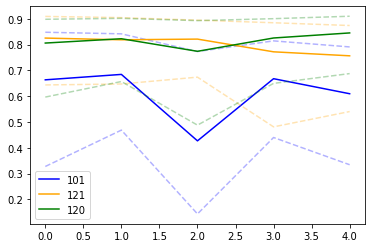

In [33]:
colors = ['blue', 'orange', 'green']
exps = ['101','121','120']

for exp, c in zip(*[exps, colors]):
    avg, best, worst = [], [], []
    for run in range(1,5+1):
        configs, results, best_test_acc = \
            ResultsIO.load(res_path, f'2021_05_28_{exp}_{run}')
        avg.append(np.mean(results.accuracy.averages))
        best.append(np.mean(results.accuracy.best))
        worst.append(np.mean(results.accuracy.worst))
        
    plt.plot(avg, label=exp, c=c)
    plt.plot(best, c=c, linestyle='--', alpha=0.3)
    plt.plot(worst, c=c, linestyle='--', alpha=0.3)
plt.legend()
plt.show()

In [37]:
import seaborn as sb
import pandas as pd

In [57]:
colors = ['blue', 'orange', 'green']
exps = ['101','121','120']
exp_names = ['Default', 'All', 'Without Comp']

best_acc_dict = dict()

for exp, c in zip(*[exps, colors]):
    best_acc = []
    for run in range(1,5+1):
        _, _, best_test_acc = \
            ResultsIO.load(res_path, f'2021_05_28_{exp}_{run}')
        best_acc.append(best_test_acc)
    best_acc_dict[exp] = best_acc

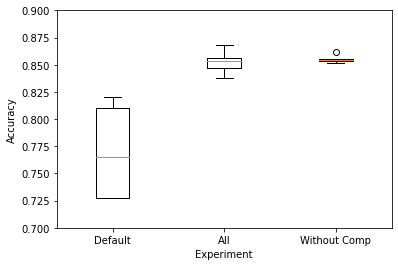

In [62]:
plt.boxplot(
    x=[best_acc_dict['101'],best_acc_dict['121'],best_acc_dict['120']],
    labels=exp_names
)
plt.ylim(0.7,0.9)
plt.xlabel('Experiment')
plt.ylabel('Accuracy')
plt.show()

In [7]:
configs

Configs: 
    pop_size:       100
    mutation_rate:  0.01
    emb_layers:     ['layer_1_act', 'layer_2_act']
    recomb_layers:  ['layer_1_linear', 'layer_2_linear', 'output']
    epochs:         1
    loss_weights:   [1, 0, 1]

In [9]:
results

Results:
    Fitness:
        Averages: 101 values, min: 0.924, max: 1.192, mean: 1.073
        Best:     101 values, min: 1.112, max: 1.362, mean: 1.208
        Worst:    101 values, min: 0.393, max: 1.102, mean: 0.836
    Accuracy:
        Averages: 101 values, min: 0.421, max: 0.815, mean: 0.663
        Best:     101 values, min: 0.750, max: 0.950, mean: 0.848
        Worst:    101 values, min: 0.010, max: 0.750, mean: 0.327
    Loss:
        Averages: 101 values, min: 0.097, max: 0.347, mean: 0.220
        Best:     101 values, min: 0.000, max: 0.186, mean: 0.109
        Worst:    101 values, min: 0.174, max: 1.102, mean: 0.440
    Compression:
        Averages: 101 values, min: 0.475, max: 0.654, mean: 0.590
        Best:     101 values, min: 0.207, max: 0.648, mean: 0.391
        Worst:    101 values, min: 0.648, max: 0.902, mean: 0.733

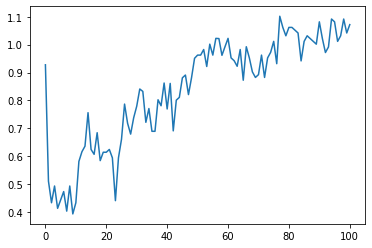

In [15]:
plt.plot(results.fitness.worst)
plt.show()